In [1]:
import random
from copy import deepcopy
from networkx import Graph, minimum_spanning_tree
import networkx as nx

class Individual:
    def __init__(self, graph, edges = None):
        self.graph = graph
        self.edges = edges or self.initialize_spanning_tree()
        self.fitness = self.calc_fitness()
    
    def initialize_spanning_tree(self):
        mst = minimum_spanning_tree(self.graph)
        return mst.edges
    
    def calc_fitness(self):
        self.graph.add_edges_from(self.edges)
        return sum(1 for node in self.graph.nodes if self.graph.degree[node] == 1)

In [2]:

def crossover(parent_1, parent_2):    
    combined_edges = list(set(parent_1.edges) | set(parent_2.edges))
    
    temp_graph = Graph()
    temp_graph.add_edges_from(combined_edges)
    child_edges = list(minimum_spanning_tree(temp_graph).edges)

    return Individual(Graph(), child_edges)

In [3]:
def mutation(individual, prob):
    if random.random() < prob:
        all_edges = list(individual.graph.edges)
        individual.edges[random.randint(0, len(individual.edges) - 1)] = random.choice(all_edges)
        individual.fitness = individual.calc_fitness()

In [4]:
def selection(population, tournament_size):
      participants = random.sample(population, tournament_size)
      return max(participants, key=lambda x: x.fitness)

In [5]:
def ga(graph, num_iters, elitism_size, prob, population_size, tournament_size):

    population = [Individual(graph) for _ in range(population_size)]
    new_population = deepcopy(population)
    
    if elitism_size % 2 != len(population) % 2:
        elitism_size += 1
    
    for _ in range(num_iters):
        population.sort(key=lambda x: x.fitness, reverse=True)
        new_population[:elitism_size] = deepcopy(population[:elitism_size])
    
    for i in range(elitism_size, population_size, 2):
        parent_1 = selection(population, tournament_size)
        parent_2 = selection(population, tournament_size)
        
        child_1 = crossover(parent_1, parent_2)
        child_2 = crossover(parent_1, parent_2)
        
        mutation(child_1, prob)
        mutation(child_2, prob)
        
        new_population[i] = child_1
        new_population[i + 1] = child_2
        
        population = deepcopy(new_population)
    
    return max(population, key=lambda x: x.fitness)

In [26]:
import matplotlib.pyplot as plt
from datetime import timedelta
import time

def test_graph(num_of_nodes,
               edge_existence_prob = 0.3,
               num_iters=30,
               elitism_size=2,
               prob=0.1,
               population_size=15,
               tournament_size=3):

    print(f"\n\nTesting a {num_of_nodes} nodes graph...")
    graph = nx.complete_graph(num_of_nodes)
    
    graph = nx.erdos_renyi_graph(num_of_nodes, edge_existence_prob)
    while not nx.is_connected(graph):
        graph = nx.erdos_renyi_graph(num_of_nodes, edge_existence_prob)
        
    start_time = time.time()
    best_solution = ga(graph, num_iters, elitism_size, prob, population_size, tournament_size)
    end_time = time.time()

    print(f"Execution time: {timedelta(seconds=end_time-start_time)}")
    print("Number of leaves:", best_solution.fitness)
    
    G = Graph()
    G.add_edges_from(best_solution.edges)
    
    node_colors = []
    for node in G.nodes():
        if G.degree[node] == 1:
            node_colors.append('red')
        else:
            node_colors.append('blue')
    
    _, axes = plt.subplots(1, 2, figsize=(10, 5))

    nx.draw(graph, node_size=10000/num_of_nodes, ax=axes[0])
    axes[0].set_title("Original graph")

    nx.draw(G, node_color=node_colors, node_size=10000/num_of_nodes, ax=axes[1])
    axes[1].set_title("Maximum leaf spanning tree")

    plt.tight_layout()
    plt.show()



Testing a 10 nodes graph...
Execution time: 0:00:00.081093
Number of leaves: 7


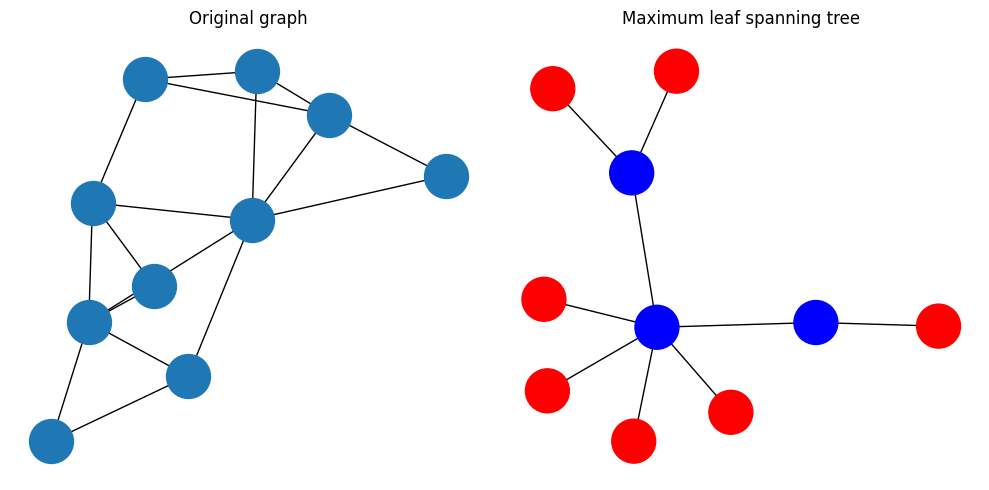



Testing a 50 nodes graph...
Execution time: 0:00:00.125035
Number of leaves: 41


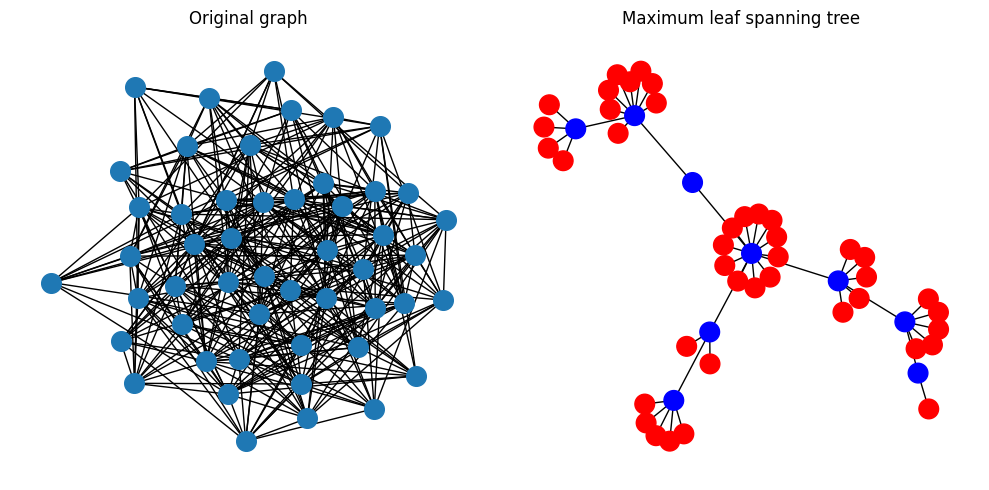



Testing a 250 nodes graph...
Execution time: 0:00:01.749287
Number of leaves: 235


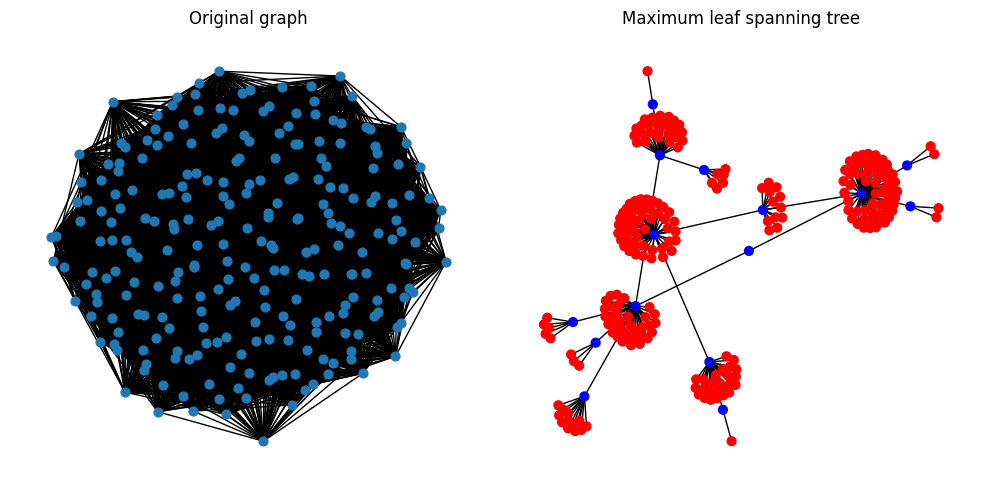



Testing a 500 nodes graph...
Execution time: 0:00:06.897081
Number of leaves: 484


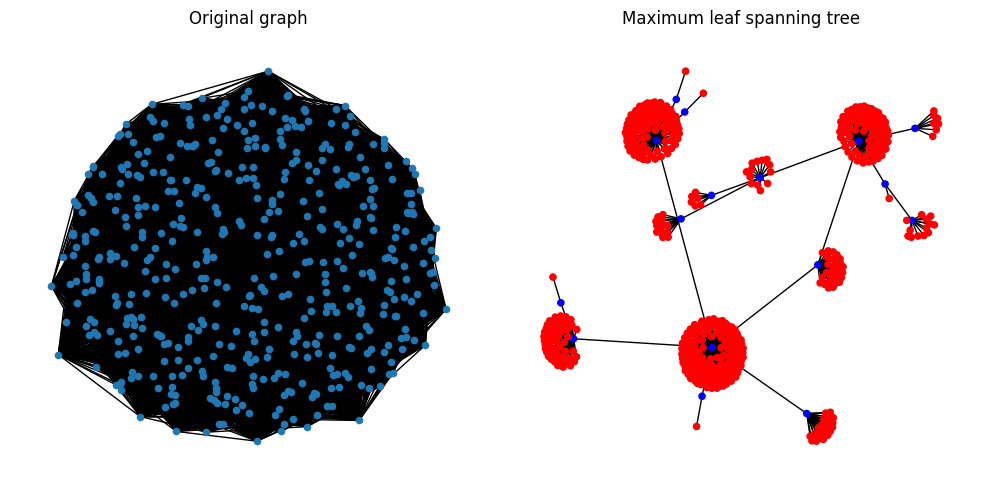



Testing a 1000 nodes graph...
Execution time: 0:00:26.930927
Number of leaves: 982


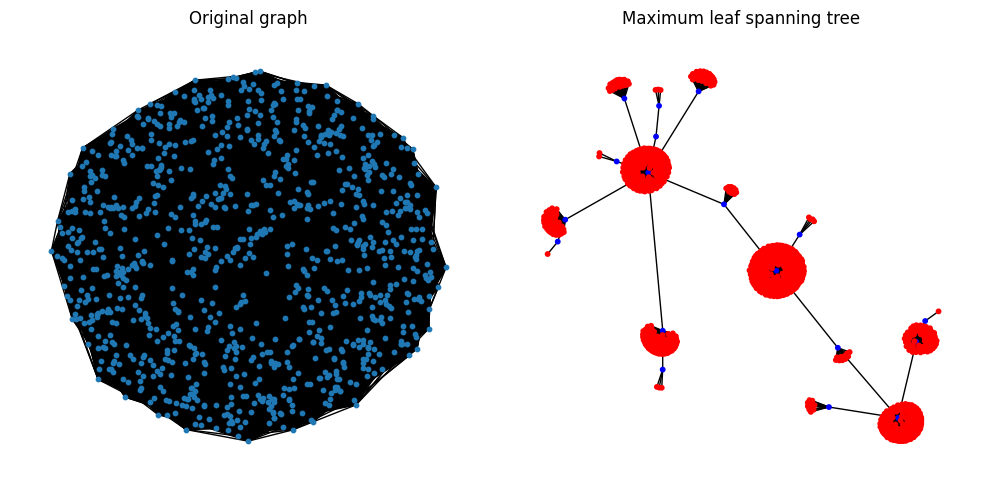

In [27]:
tests = [10, 50, 250, 500, 1000]
for t in tests:
    test_graph(t)